In [ ]:
!pip install -e dsci_2022

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import os
# os.environ['TRANSFORMERS_OFFLINE'] = '1' # Indicating transformers for offline mode
# from functools import partial
from pathlib import Path
from tokenizers import Tokenizer
from transformers import AutoTokenizer, AutoModel
import transformers
# from transformers.models.auto.tokenization_auto import logger
# import random
import torch
# import torchmetrics
# import torch.nn as nn
# from torch.utils import data
# from torch.utils.data import Dataset, DataLoader, random_split
# import pytorch_lightning as pl
import importlib
import re

transformers.logging.set_verbosity_error()
TRANSFORMER_CACHE = Path("../resources/transformer_cache") # The cache location. Accessed when offline.

In [5]:
import dsci_2022
from dsci_2022.utils import *

#### Model

In [6]:
# This is required to initialize the backend-model (bert) which is a pretrained model.
importlib.reload(dsci_2022.chunksumm)
pretrained_model = AutoModel.from_pretrained('../resources/checkpoints/bert-base-uncased.pt')
tokenizer = AutoTokenizer.from_pretrained('../resources/checkpoints/bert-base-uncased-tokenizer.pt')
model = dsci_2022.chunksumm.CHUNKSUMM(model = pretrained_model)

/home/amanjais/bd/ENV/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/amanjais/bd/ENV/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(


#### Load Checkpoints

In [4]:
#loading model checkpoint
first = torch.load('../resources/checkpoints/first.pt') # initial model
second_40k = torch.load('../resources/checkpoints/second-40k.pt') # Traning with 40k sentences
model.load_state_dict(second_40k) 
# model.cuda()
model.enable_chunk = True

In [ ]:
dsci_20

In [ ]:
dsci_2022.chunksumm.SummDataModule

### Inference

In [5]:
importlib.reload(dsci_2022.chunksumm)
"This is a test"
batch_text = "This is a test"
tokens, probs = dsci_2022.chunksumm.get_token_scores(model, tokenizer, batch_text)

In [6]:
tokens.shape # batch * tokens   

torch.Size([1, 6])

In [7]:
probs[:,:,0] # batch * tokens * probability

tensor([[0.0006, 0.0008, 0.0007, 0.0005, 0.0007, 0.0009]],
       grad_fn=<SelectBackward0>)

In [8]:
probs

tensor([[[5.7740e-04, 9.9942e-01],
         [7.7118e-04, 9.9923e-01],
         [6.7593e-04, 9.9932e-01],
         [4.9304e-04, 9.9951e-01],
         [6.7584e-04, 9.9932e-01],
         [9.2531e-04, 9.9907e-01]]], grad_fn=<SoftmaxBackward0>)

In [9]:
probs[:,:,0].shape

torch.Size([1, 6])

# testing

In [10]:
labels = pd.read_pickle("../data/labels.pkl")
show(labels)

(372564, 5)


,paper_id,sentence,text,sentence_score,in_summary
0,0,0,Proceedings of the 56th Annual Meeting of the ...,NaN,False
1,0,1,Parsing has been useful for incorporating ling...,NaN,False
2,0,2,Neural network-based approaches relying on den...,NaN,False
3,0,3,"Generally speaking, either these approaches pr...",NaN,False
4,0,4,Corresponding authors: yikang.shen@umontreal.c...,NaN,False


In [11]:
example_raw = labels.query("paper_id == 0")\
.sort_values("sentence")\
.text.map(lambda x: x + "\n").sum()

print(len(example_raw))
print(example_raw[:1500])

22373
Proceedings of the 56th Annual Meeting of the Association for Computational Linguistics (Long Papers), pages 1171–1180 Melbourne, Australia, July 15 - 20, 2018. c©2018 Association for Computational Linguistics
1171
Devising fast and accurate constituency parsing algorithms is an important, long-standing problem in natural language processing.
Parsing has been useful for incorporating linguistic prior in several related tasks, such as relation extraction, paraphrase detection (Callison-Burch, 2008), and more recently, natural language inference (Bowman et al., 2016) and machine translation (Eriguchi et al., 2017).
Neural network-based approaches relying on dense input representations have recently achieved competitive results for constituency parsing (Vinyals et al., 2015; Cross and Huang, 2016; Liu and Zhang, 2017b; Stern et al., 2017a).
Generally speaking, either these approaches produce the parse tree sequentially, by governing
∗Equal contribution.
Corresponding authors: yikang

In [12]:
%%time

importlib.reload(dsci_2022.chunksumm)
tokens, probs = dsci_2022.chunksumm.get_token_scores(model, tokenizer, example_raw)
tokens.shape, probs.shape
# (torch.Size([1, 5353]), torch.Size([1, 512, 2])) is truncating the output

CPU times: user 11.9 s, sys: 1.18 s, total: 13.1 s
Wall time: 11.9 s


(torch.Size([1, 5353]), torch.Size([1, 5353, 2]))

In [13]:
results = list(zip(tokens.squeeze().tolist(), probs[0, :, 0].tolist()))
results[:5]

[(101, 3.446861956035718e-05),
 (8931, 1.0457250027684495e-05),
 (1997, 9.249171853298321e-06),
 (1996, 1.0250551895296667e-05),
 (29087, 7.202426331787137e-06)]

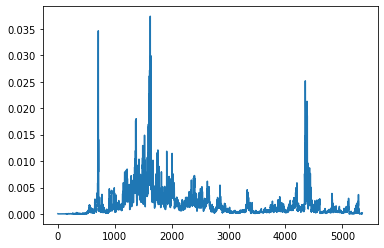

In [14]:
plt.plot([s for w, s in results])

In [15]:
pd.Series([s for w, s in results]).describe(np.linspace(0, 1, 11))

count    5353.000000
mean        0.001728
std         0.002595
min         0.000006
0%          0.000006
10%         0.000092
20%         0.000283
30%         0.000429
40%         0.000609
50%         0.000861
60%         0.001211
70%         0.001774
80%         0.002595
90%         0.004182
100%        0.037382
max         0.037382
dtype: float64

In [16]:
%%time

importlib.reload(dsci_2022.utils)
spans = dsci_2022.utils.extract_spans(
    results, 
    0.01,
#     0.005,
)
# print([len(l) for l in spans])
# spans[0][:10]

tok_ids = [(sum([s for w, s in l]) / len(l), [w for w, s in l]) for l in spans]
# print([len(l) for l in tok_ids])
# tok_ids[:5]

sorted([(s, tokenizer.decode(l)) for s, l in tok_ids], key = lambda x: x[0], reverse = True)

CPU times: user 4.05 ms, sys: 798 µs, total: 4.85 ms
Wall time: 6.12 ms


[(0.018326123378106525,
  'end function ( pos ) tags of each word in the left -'),
 (0.017931616077056296,
  'easy parallelization in modern parallel computing architectures for deep learning,'),
 (0.015952431563554064, 'in modern gpu architectures.'),
 (0.01582790957763791, '10 :'),
 (0.015748022124171257, 'right order. d is'),
 (0.01569296489469707, 'return node 11 :'),
 (0.014809214975684881, 'more natural setting for models based on'),
 (0.014489921275526285, 'to -'),
 (0.01411837071646005, 'ci ) 9 :'),
 (0.013278688595164567, 'words in the input sentence ) divide -'),
 (0.012428981096794208, ') 8 :'),
 (0.01219220389612019, '##rs,'),
 (0.0118623748421669, 'conquer algorithm.'),
 (0.011633045195291439, 'node← node ( childl'),
 (0.010999273741617799, '2 :'),
 (0.010667683556675911, 'node in'),
 (0.010425901350875696, 'sequence of scala'),
 (0.010335774626582861, '1 :'),
 (0.009752318263053894, 'function tree ('),
 (0.009747159977753958, 'be batched'),
 (0.0095757309657832, 'such as 

In [24]:
%%time

importlib.reload(dsci_2022.utils)
summary = dsci_2022.utils.produce_summary(results, tokenizer, 0.01)
summary

CPU times: user 5.32 ms, sys: 1.06 ms, total: 6.39 ms
Wall time: 8.1 ms


[(0.018326123378106525,
  'end function ( pos ) tags of each word in the left -'),
 (0.017931616077056296,
  'easy parallelization in modern parallel computing architectures for deep learning,'),
 (0.015952431563554064, 'in modern gpu architectures.'),
 (0.01582790957763791, '10 :'),
 (0.015748022124171257, 'right order. d is'),
 (0.01569296489469707, 'return node 11 :'),
 (0.014809214975684881, 'more natural setting for models based on'),
 (0.014489921275526285, 'to -'),
 (0.01411837071646005, 'ci ) 9 :'),
 (0.013278688595164567, 'words in the input sentence ) divide -'),
 (0.012428981096794208, ') 8 :'),
 (0.01219220389612019, '##rs,'),
 (0.0118623748421669, 'conquer algorithm.'),
 (0.011633045195291439, 'node← node ( childl'),
 (0.010999273741617799, '2 :'),
 (0.010667683556675911, 'node in'),
 (0.010425901350875696, 'sequence of scala'),
 (0.010335774626582861, '1 :'),
 (0.009752318263053894, 'function tree ('),
 (0.009747159977753958, 'be batched'),
 (0.0095757309657832, 'such as 